# Подключение библиотек и загрузка датасет

In [ ]:
import os
import random
import shutil

from multiprocessing.dummy import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
import joblib

from skimage.morphology import binary_opening, disk, label

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

In [ ]:
!pip install opendatasets --quiet

In [ ]:
# по API подключаемся к kaggle и скачиваем нужный датасет
# для этого в colab надо подгрузить файл kaggle.json, который содержит токен и пароль
# после этого в проводнике colab появится папка с данными
import opendatasets as od
import pandas as pd

# {"username":"adele1997","key":"b455b34a14df6c01a6a95866d44d6f13"}
od.download( "https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adele1997
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation


100%|██████████| 1.61G/1.61G [00:09<00:00, 185MB/s]


In [ ]:
import os
import pandas as pd

train_df = pd.read_csv('/content/chest-ct-segmentation/train.csv')

print(train_df.shape)
print(len(os.listdir('/content/chest-ct-segmentation/images/images')))
print(len(os.listdir('/content/chest-ct-segmentation/masks/masks')))

(16708, 2)
17011
16708


In [ ]:
train_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


# Изучение датасета

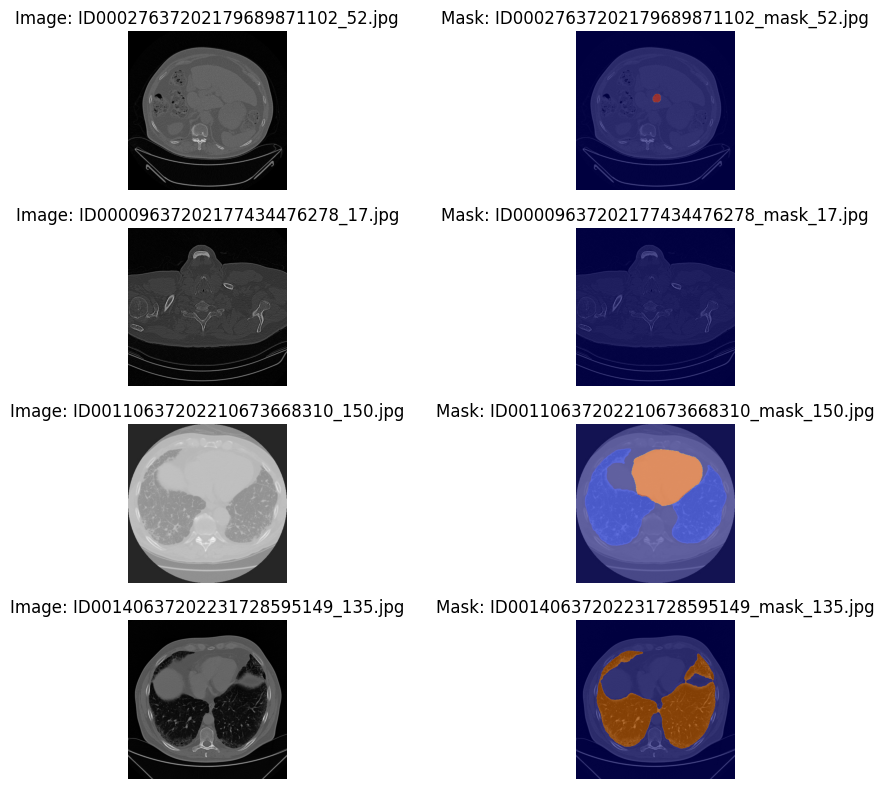

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2  # Для чтения png
import pandas as pd

# Пути к папкам
images_dir = '/content/chest-ct-segmentation/images/images'
masks_dir = '/content/chest-ct-segmentation/masks/masks'

# Читаем датафрейм
train_df = pd.read_csv('/content/chest-ct-segmentation/train.csv')

# Случайно выбираем 4 индекса
sample_rows = train_df.sample(4, random_state=42)

plt.figure(figsize=(12, 8))

for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img_name = row['ImageId']  # Имя файла изображения, например "123.png"
    mask_name = row['MaskId']  # Имя файла маски

    # Полные пути
    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)

    # Читаем изображения (cv2 читает в BGR)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Маска в оттенках серого

    # Отображаем изображение
    plt.subplot(4, 2, 2*i - 1)
    plt.imshow(img)
    plt.title(f'Image: {img_name}')
    plt.axis('off')

    # Отображаем маску поверх изображения с прозрачностью
    plt.subplot(4, 2, 2*i)
    plt.imshow(img)
    plt.imshow(mask, cmap='jet', alpha=0.5)  # маска с прозрачностью и цветовой картой
    plt.title(f'Mask: {mask_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

sample_rows = train_df.sample(1)

sample_rows

,ImageId,MaskId
8581,ID00196637202246668775836_100.jpg,ID00196637202246668775836_mask_100.jpg


In [ ]:
sample_rows['ImageId'].values[0]

'ID00169637202238024117706_90.jpg'

In [ ]:
img_name = sample_rows['ImageId'].values[0]  # Имя файла изображения, например "123.png"
mask_name = sample_rows['MaskId'].values[0]  # Имя файла маски

# Полные пути
img_path = os.path.join(images_dir, img_name)
mask_path = os.path.join(masks_dir, mask_name)

# Читаем изображения (cv2 читает в BGR)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Маска

mask_values = np.unique(mask)
print(f"Unique mask values (classes): {mask_values}")

Unique mask values (classes): [ 0  1  2  3  4  5  6  7 12 14 15 16 17 18 19 20 21 22 32 34 40 43 53 54
 55 56 57 58 60 61 62 63 64 66 68 69 71 72 73 74 75 76 77 78 79 80 81 82]


In [ ]:
train_df.sample(1)

,ImageId,MaskId
10728,ID00249637202266730854017_23.jpg,ID00249637202266730854017_mask_23.jpg


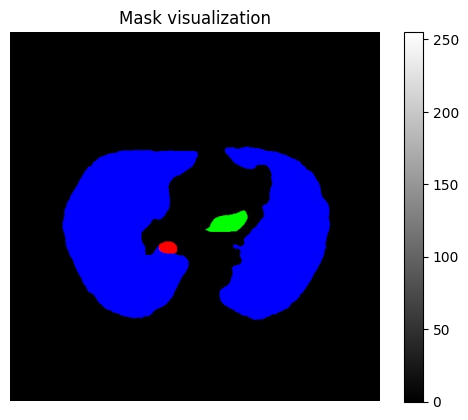

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

sample_rows = train_df.sample(1)
# Загрузка маски из файла (если у тебя png)
mask_path = sample_rows['MaskId'].values[0]
mask = np.array(Image.open(os.path.join(masks_dir, mask_path)))

# Визуализация маски
plt.imshow(mask, cmap='gray')  # можно заменить 'gray' на 'viridis' или 'jet', чтобы увидеть разные цвета
plt.colorbar()  # отображает легенду цветов
plt.title('Mask visualization')
plt.axis('off')  # скрыть оси
plt.show()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
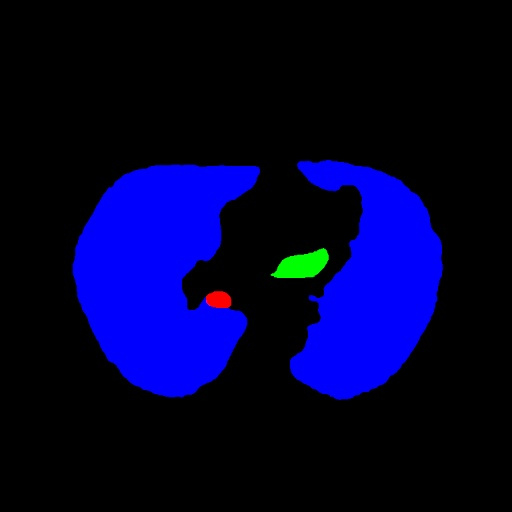

In [ ]:
mask

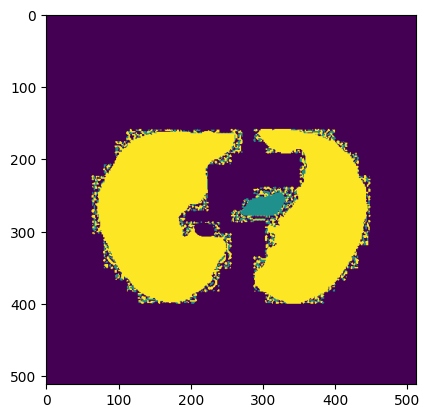

In [ ]:
res = np.argmax(mask, axis=-1).astype(np.uint8)
plt.imshow(res)

In [ ]:
np.unique(mask)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
# какой то код
res =  ....
np.unique(res)

array([0, 1, 2, 3])

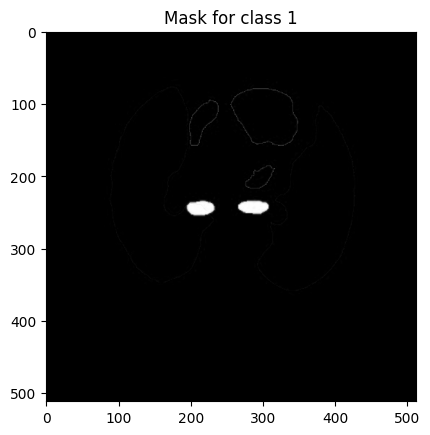

In [ ]:
# mask.shape == (H, W, C)
mask_class_1 = mask[:,:,0]

plt.imshow(mask_class_1, cmap='gray')
plt.title("Mask for class 1")
plt.show()

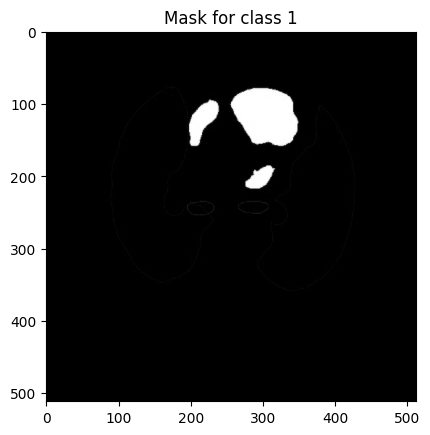

In [ ]:
# mask.shape == (H, W, C)
mask_class_1 = mask[:,:,1]

plt.imshow(mask_class_1, cmap='gray')
plt.title("Mask for class 1")
plt.show()

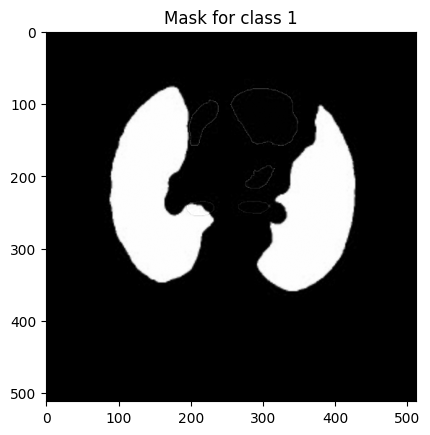

In [ ]:
# mask.shape == (H, W, C)
mask_class_1 = mask[:,:,2]

plt.imshow(mask_class_1, cmap='gray')
plt.title("Mask for class 1")
plt.show()

In [ ]:
mask.shape

(512, 512, 3)

# Подготовка данных

In [ ]:
arr = np.array([
    [
        [1,3,4],
        [1,3,4],
        [1,3,4]
    ],
    [
        [1,0,0],
        [1,0,0],
        [1,3,4]
    ],
])
print(arr.shape)
np.argmax(arr, axis=-1)

(2, 3, 3)


array([[2, 2, 2],
       [0, 0, 2]])

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

import pandas as pd

class SegmentationDataset(Dataset):
    def __init__(self, csv_path, image_dir, mask_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx] # Series

        img_path = os.path.join(self.image_dir, row['ImageId'])
        mask_path = os.path.join(self.mask_dir, row['MaskId'])

        # Загрузка
        image = Image.open(img_path).convert("RGB") # Image
        mask = np.array(Image.open(mask_path)) # numpy # shape: (H, W, 3)

        # Перевод в индексы классов
        # доп код
        mask_class = np.argmax(mask, axis=-1).astype(np.uint8) # numpy  array

        # Аугментации
        # mask_class - np.array
        # image - np.array
        if self.transform:
            augmented = self.transform(image=np.array(image), mask=mask_class)
            image = augmented['image']
            mask_class = augmented['mask']

        image = transforms.ToTensor()(image)
        mask_class = torch.from_numpy(mask_class).long()

        return image, mask_class

In [ ]:
import albumentations as A
from torch.utils.data import Dataset
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

# transforms.Compose([])
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], additional_targets={'mask': 'mask'})

In [ ]:
train_dataset = SegmentationDataset(
    csv_path='/content/chest-ct-segmentation/train.csv',
    image_dir='/content/chest-ct-segmentation/images/images',
    mask_dir='/content/chest-ct-segmentation/masks/masks',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
for images, masks in train_loader:
    print("Image batch shape:", images.shape)  # [B, 3, H, W]
    print("Mask batch shape:", masks.shape)    # [B, H, W]
    print("Unique labels in first mask:", torch.unique(masks[0]))
    break  # только первый батч

Image batch shape: torch.Size([8, 3, 512, 512])
Mask batch shape: torch.Size([8, 512, 512])
Unique labels in first mask: tensor([0, 1, 2])


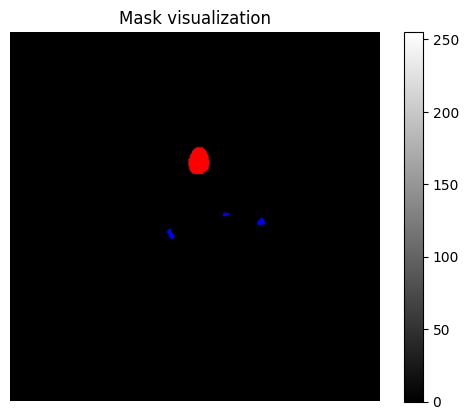

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Пути к файлам
img_path = train_df.iloc[0]['ImageId']
mask_path = train_df.iloc[0]['MaskId']

mask = np.array(Image.open(os.path.join(masks_dir, mask_path)))

# Визуализация маски
plt.imshow(mask, cmap='gray')  # можно заменить 'gray' на 'viridis' или 'jet', чтобы увидеть разные цвета
plt.colorbar()  # отображает легенду цветов
plt.title('Mask visualization')
plt.axis('off')  # скрыть оси
plt.show()

# Построение модели

In [ ]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [ ]:
class DownConv(nn.Module):
    """
    Свёрточный модуль.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    Развёрточный модуль.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Прямой проход
        Arguments:
            from_down: тензор из прохода, который приводил к понижению размерности
            from_up: тензор из текущего прохода, приводяйщий к росту
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [ ]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [ ]:
# СОЗДАЕМ МОДЕЛЬ
model = UNet(num_classes=3, in_channels=3, depth=5)

<ipython-input-113-96850bffd297>:98: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(m.weight)
<ipython-input-113-96850bffd297>:99: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(m.bias, 0)


In [ ]:
# class customLoss():
#     self.loss1 =
#     self.loss2 =

#     return loss1 + loss2

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # не надо softmax в модели!
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)         # [B, 3, H, W]
        loss = criterion(outputs, masks)  # [B, H, W] с int метками

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Train batch loss = {loss.item():.4f}")

    return running_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)  # [B, 3, H, W]
            preds = torch.argmax(outputs, dim=1)  # [B, H, W]

            # Пример метрики: DICE для каждого класса
            for c in range(3):
                pred_c = (preds == c).float()
                true_c = (masks == c).float()

                intersection = (pred_c * true_c).sum()
                dice = (2. * intersection) / (pred_c.sum() + true_c.sum() + 1e-8)
                dice_scores.append(dice.item())

            print(f"Val batch dice_scores = {dice.item():.4f}")

    return sum(dice_scores)/len(dice_scores)

In [ ]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

for epoch in tqdm(range(1, 3)):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_score = evaluate(model, train_loader, device)
    print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val DICE = {val_score:.4f}")

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Train batch loss = 0.1601
Train batch loss = 0.3752
Train batch loss = 0.1877
Train batch loss = 0.3438
Train batch loss = 0.2231
Train batch loss = 0.3117
Train batch loss = 0.3270
Train batch loss = 0.2116
Train batch loss = 0.2427
Train batch loss = 0.2768
Train batch loss = 0.3447
Train batch loss = 0.3527
Train batch loss = 0.3081
Train batch loss = 0.2554
Train batch loss = 0.2783
Train batch loss = 0.2471
Train batch loss = 0.1242
Train batch loss = 0.2359
Train batch loss = 0.1746
Train batch loss = 0.2222
Train batch loss = 0.4537
Train batch loss = 0.2874
Train batch loss = 0.3360
Train batch loss = 0.2968
Train batch loss = 0.2780
Train batch loss = 0.2043
Train batch loss = 0.3569
Train batch loss = 0.3851
Train batch loss = 0.3236
Train batch loss = 0.3265
Train batch loss = 0.2838
Train batch loss = 0.2499
Train batch loss = 0.3397
Train batch loss = 0.3114
Train batch loss = 0.3879
Train batch loss = 0.2777
Train batch loss = 0.2321
Train batch loss = 0.2567
Train batch 

In [ ]:
# # Сохранить
torch.save(model.state_dict(), "unet_model.pth")

# # Загрузить
# model.load_state_dict(torch.load("unet_model.pth"))
# model.eval()

In [ ]:
model.eval()  # переводим модель в режим eval

# Берем один батч из train_loader
inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

# Предсказания
with torch.no_grad():
    outputs = model(inputs)  # [B, C, H, W]
    preds = torch.argmax(outputs, dim=1)  # [B, H, W]
    gts = torch.argmax(targets, dim=1) if targets.shape[1] > 1 else targets.squeeze(1)  # если one-hot

# Переводим на CPU и в numpy
image = inputs[0].permute(1, 2, 0).cpu().numpy()
mask_pred = preds[0].cpu().numpy()
mask_true = gts[0].cpu().numpy()

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_true, cmap='jet')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mask_pred, cmap='jet')
plt.title("Prediction")
plt.axis("off")

plt.tight_layout()
plt.show()